In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import code.data_utils as data_utils
from IPython.core.debugger import Pdb
%matplotlib inline

In [2]:
beg_prob = np.load('beg_prob.npy')

In [3]:
end_p = np.load('end_prob.npy')

In [4]:
beg_df= pd.DataFrame(beg_prob)

In [5]:
end_df= pd.DataFrame(end_p)

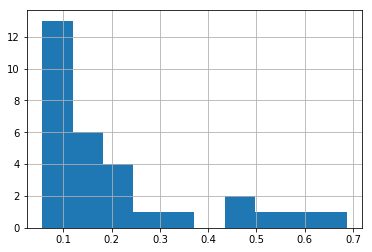

In [6]:
beg_df.max(axis=1).hist()

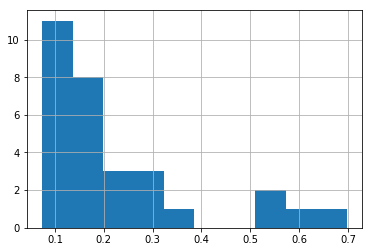

In [7]:
end_df.max(axis=1).hist()

In [8]:
logs = pd.read_table('train_logs.txt', sep=',', names=['f1', 'loss', 'grad_norm', 'ans_span', 'max_beg_prob', 'max_end_prob', 'val_loss', 'val_f1'])

In [9]:
logs.loss.max()

9.3048953277299997

In [10]:
logs

,f1,loss,grad_norm,ans_span,max_beg_prob,max_end_prob,val_loss,val_f1
0,3.128275,9.304895,3.032193,0.0,0.074908,0.102836,7.794555,5.698006
1,7.055917,7.976442,3.188796,0.0,0.087916,0.127223,7.431131,5.459910
2,8.059105,7.774617,3.659966,0.0,0.073176,0.125651,7.340400,5.831095
3,8.780175,7.621700,4.271715,0.0,0.138570,0.136007,7.219936,7.643061
4,10.836155,7.396634,5.608130,0.0,0.138564,0.165850,7.060682,7.706960
5,12.642067,7.167609,7.765551,0.0,0.120594,0.125762,7.125540,9.065324
6,13.977704,6.957783,11.866274,0.0,0.132959,0.149335,6.930682,9.210623
7,15.753322,6.728757,16.224262,0.0,0.249447,0.278496,7.022887,9.321937
8,16.696168,6.527778,13.927075,0.0,0.194313,0.213761,6.993663,8.608262
9,18.747739,6.326583,9.625211,0.0,0.192387,0.227205,6.964870,9.258445


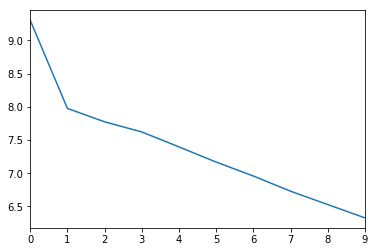

In [11]:
ax = plt.subplot()
logs.loss.plot(ax=ax)

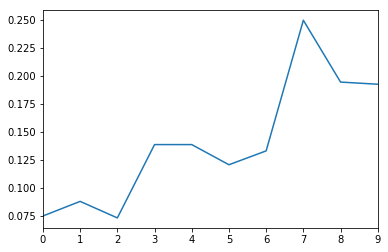

In [12]:
logs.max_beg_prob.plot()

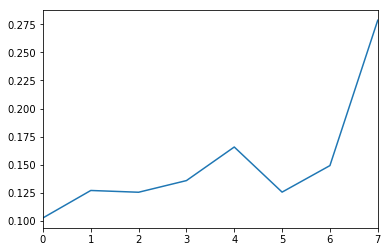

In [13]:
logs.max_end_prob.plot()

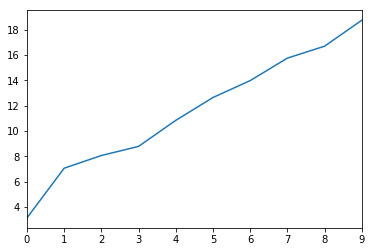

In [13]:
logs.f1.plot()

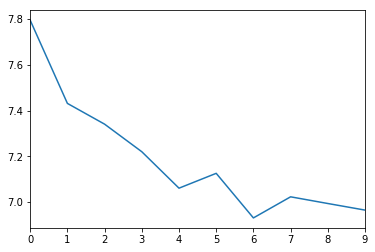

In [15]:
ax = plt.subplot()
logs.val_loss.plot(ax=ax)

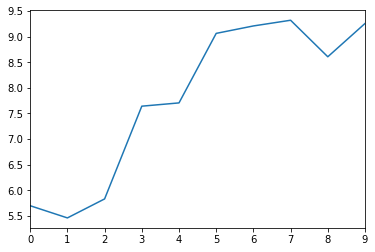

In [14]:
ax = plt.subplot()
logs.val_f1.plot(ax=ax)

You would like to not have that burn in period when the model is putting all of its mass on one word. How would you do that? What can you do to figure it out? You could check out a new branch and step into your model at epoch 10?

In [3]:
data_dir = os.path.join(os.getcwd(), 'data', 'squad')

In [4]:
data_dir

'/home/ryanryanadmin/Documents/ds/nlp/assignment4/data/squad'

In [24]:
def get_lengths(file_name):
    lengths = []
    with open(os.path.join(data_dir, file_name), 'r') as f:
        for l in f:
            l_arr = l.split()
            lengths.append(len(l_arr))
    return lengths

In [25]:
context_len = get_lengths('train.ids.context')
quest_len = get_lengths('train.ids.question')

In [28]:
sorted_quest = sorted(quest_len)

In [43]:
sorted_quest[-10]

36

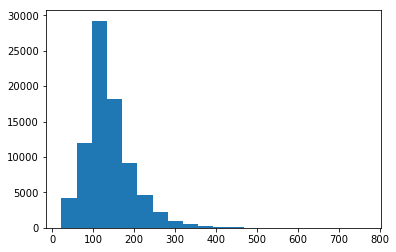

In [6]:
_ = plt.hist(context_len, bins=20)

In [7]:
np.percentile(np.array(context_len), 95)

244.0

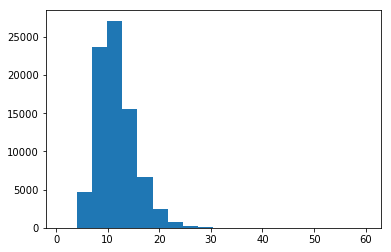

In [8]:
_ = plt.hist(quest_len, bins=20)

In [9]:
np.percentile(np.array(quest_len), 95)

18.0

In [10]:
def get_answer_info(file_name):
    info = []
    with open(os.path.join(data_dir, file_name), 'r') as f:
        for l in f:
            l_arr = l.split()
            start, end = int(l_arr[0]), int(l_arr[1])
            length = end - start
            info.append([start, end, length])
    return np.array(info)

In [11]:
ans_info = get_answer_info('train.span')

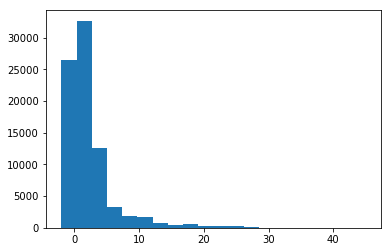

In [14]:
_ = plt.hist(ans_info[:, 2], bins=20)

In [43]:
np.percentile(ans_info[:, 2], 95)

10.0

In [19]:
cols = ['con_len', 'ans_start', 'ans_end', 'ans_len']
info_df = pd.DataFrame(np.hstack((np.array(context_len)[:, np.newaxis], ans_info)), columns=cols)

In [21]:
info_df.head()

,con_len,ans_start,ans_end,ans_len
0,86,7,7,0
1,144,136,137,1
2,149,117,118,1
3,109,23,25,2
4,94,28,30,2


In [26]:
len(info_df)

81403

In [38]:
1.0 *(info_df.ans_end > 200).sum() / len(info_df) * 1.0

0.014680048646855766

The longer the context, the longer it will take your model to train.

The handout mentions controlling the length of your output. What does that mean? Does that mean figuring out how long the answers tend to be, and building your model so it ouputs answers of reasonable lengths? If so, an max answer length of 20-25 would cover that vast majority of training examples.

In [10]:
def gather_lines(file_name, idx=[]):
    gathered = []
    with open(os.path.join(data_dir, file_name), 'r') as f:
        for i, l in enumerate(f):
            if i in idx:
                gathered.append(l)
    return np.array(gathered)

In [53]:
idx = np.random.randint(0, len(context_len), 20)
quests = gather_lines(os.path.join(data_dir, 'train.question'), idx)
context = gather_lines(os.path.join(data_dir, 'train.context'), idx)
answer = gather_lines(os.path.join(data_dir, 'train.answer'), idx)


In [68]:
info = np.hstack((quests[:, np.newaxis], context[:, np.newaxis], answer[:, np.newaxis]))

In [67]:
context.shape

(20,)

In [69]:
def info_gen(info):
    for i in np.arange(info.shape[0]):
        yield(info[i, :])

In [70]:
get_info = info_gen(info)

In [75]:
get_info.next()

array(['In what year did the establishment of the Qutb dynasty occur ?\n',
       'Sultan Quli , a governor of Golkonda , revolted against the Bahmani Sultanate and established the Qutb Shahi dynasty in 1518 ; he rebuilt the mud-fort of Golconda and named the city " Muhammad nagar " . The fifth sultan , Muhammad Quli Qutb Shah , established Hyderabad on the banks of the Musi River in 1591 , to avoid the water shortages experienced at Golkonda . During his rule , he had the Charminar and Mecca Masjid built in the city . On 21 September 1687 , the Golkonda Sultanate came under the rule of the Mughal emperor Aurangzeb after a year-long siege of the Golkonda fort . The annexed area was renamed Deccan Suba ( Deccan province ) and the capital was moved from Golkonda to Aurangabad , about 550 km ( 342 mi ) northwest of Hyderabad .\n',
       '1518\n'], 
      dtype='|S1563')

# Look at npz

In [46]:
with np.load(os.path.join(data_dir, 'glove.trimmed.100.npz'), mmap_mode='r') as embed:
    print(embed['glove'].shape)
    

(115240, 100)


In [20]:
embed_path = os.path.join(os.getcwd(), 'download','dwr', 'glove.6B.100d.txt')
with open(embed_path, 'r') as f:
    for line in f:
        array = line.lstrip().rstrip().split(" ")
        #take the first element -- it must be the key and the rest must be the actual word embedding elements
        word = array[0]
        if word == 'the':
            print('found ', word)
            print(array)
            break
        
        
        

found  the
['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538'

In [19]:
os.path.join(data_dir, 'glove.trimmed.100.npz')

'/home/ryanryanadmin/Documents/ds/nlp/assignment4/data/squad/glove.trimmed.100.npz'

# Check things

In [5]:
cont_length = 200
quest_length = 35
pad_token = 0
prepend = 'samp.'

In [6]:
context_data = data_utils.read_clip_and_pad(os.path.join(data_dir, prepend+'train.ids.context'), cont_length, pad_token)
question_data = data_utils.read_clip_and_pad(os.path.join(data_dir, prepend+'train.ids.question'), quest_length, pad_token)
answer_data = np.array(data_utils.read_datafile(os.path.join(data_dir, prepend+'train.span')), dtype=np.int32)
dense_answers = data_utils.make_dense_answers(answer_data, cont_length)
dataset = [question_data, context_data, answer_data]

In [11]:
questions = gather_lines('train.question', np.arange(1000))

In [14]:
context = gather_lines('train.context', np.arange(1000))

In [60]:
def check_ans(dense_answers, questions, context):
    for i in np.arange(len(dense_answers)):
        idx = np.nonzero(dense_answers[i, :])[0]
        conn_list = context[i].split(" ")
        print(idx)
        ans = np.array(conn_list)[idx]
        print(ans)
        yield questions[i], ans, context[i]

In [71]:
check_gen = check_ans(dense_answers, questions, context)

In [86]:
check_gen.next()


[15 16]
['William' 'Penn']


('Who founded the Pennsylvania colony ?\n', array(['William', 'Penn'], 
       dtype='|S12'), 'In 1681 , in partial repayment of a debt , Charles II of England granted William Penn a charter for what would become the Pennsylvania colony . Despite the royal charter , Penn bought the land from the local Lenape to be on good terms with the Native Americans and ensure peace for his colony . Penn made a treaty of friendship with Lenape chief Tammany under an elm tree at Shackamaxon , in what is now the city \'s Fishtown section . Penn named the city Philadelphia , which is Greek for brotherly love ( from philos , " love " or " friendship " , and adelphos , " brother " ) . As a Quaker , Penn had experienced religious persecution and wanted his colony to be a place where anyone could worship freely . This tolerance , far more than afforded by most other colonies , led to better relations with the local Native tribes and fostered Philadelphia \'s rapid growth into America \'s most important ci

In [7]:
dense_answers.shape

(999, 200)